<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
from pathlib import Path
path = Path('/kaggle/input/faces-dataset-small/faces_dataset_small')

In [5]:
file_dir = list(path.rglob('*png'))

In [6]:
from PIL import Image
class Images(Dataset):
    def __init__(self, path):
        super().__init__()
        self.files = path
        self.len_ = len(path)
    def __len__(self):
        return self.len_
    def load(self, item):
        image = Image.open(item)
        image.load()
        return image
    def __getitem__(self, index):
        transform = tt.Compose([
            tt.Resize(size=(128, 128)),
            tt.ToTensor(),
            tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load(self.files[index])
        x = transform(x)
        return x

In [7]:
stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
def denorm(x):
    return x * stats[1][0] + stats[0][0]

In [8]:
#train_size = int(len(file_dir) * 0.8)
#val_size = len(file_dir) - train_size

In [9]:
dataset = Images(file_dir)
#g_cpu = torch.Generator().manual_seed(42)
#train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

In [10]:
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
len(train_loader)

99

In [11]:
def plot_dataset(data):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im = data[random_characters].data.cpu()
        im = im.numpy().transpose((1, 2, 0)) 
        fig_x.imshow(im) 
        fig_x.grid(False) 

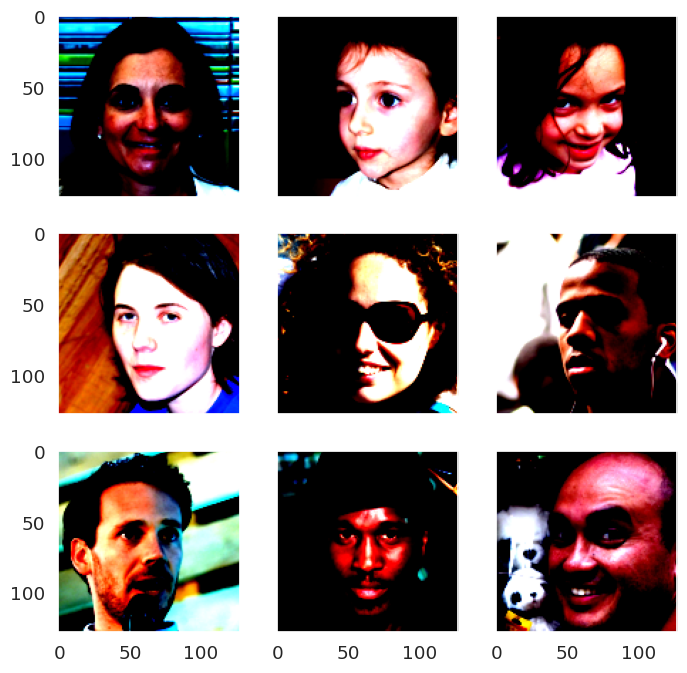

In [12]:
plot_dataset(dataset)

In [13]:
for x in train_loader:
    print(x.shape)
    break

torch.Size([32, 3, 128, 128])


## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.filters = 16
        self.block = nn.Sequential(
            nn.Conv2d(3, self.filters, kernel_size=4, stride=2, padding=1, bias=False),
            # 128x128 -> 64x64
            nn.BatchNorm2d(self.filters),
            nn.ReLU(),
            nn.Conv2d(self.filters, self.filters*2, kernel_size=4, stride=2, padding=1, bias=False),
            # 64x64 -> 32x32
            nn.BatchNorm2d(self.filters*2),
            nn.ReLU(),
            nn.Conv2d(self.filters*2, self.filters*4, kernel_size=4, stride=2, padding=1, bias=False),
            # 32x32 -> 16x16
            nn.BatchNorm2d(self.filters*4),
            nn.ReLU(),
            nn.Conv2d(self.filters*4, self.filters*8, kernel_size=4, stride=2, padding=1, bias=False),
            # 16x16 -> 8x8
            nn.BatchNorm2d(self.filters*8),
            nn.ReLU(),
            nn.Conv2d(self.filters*8, self.filters*16, kernel_size=4, stride=2, padding=1, bias=False),
            # 8x8 -> 4x4
            nn.BatchNorm2d(self.filters*16),
            nn.ReLU(),
            nn.Conv2d(self.filters*16, 1, kernel_size=4, stride=1, padding=0, bias=False)
            # 4x4 -> 1x1
        )
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.block(x)
        x = self.flatten(x)
        x = self.sigmoid(x)
        return x

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # input size = latent_size x 1 x 1
        self.block = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # latent_size x 1 x 1 -> 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 512 x 4 x 4 -> 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 256 x 8 x 8-> 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 128 x 16 x 16-> 128 x 32 x 32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 64 x 32 x 32-> 32 x 64 x 64
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # 32 x 64 x 64-> 3 x 128 x 128
        )
    def forward(self, x):
        x = self.block(x)
        return x

In [16]:
latent_size = 128

In [17]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [18]:
fixed_latent.shape

torch.Size([64, 128, 1, 1])

In [19]:
from IPython.display import clear_output
from torchvision.utils import make_grid
# функция для отрисовки изображений которые генерирует генератор
def show_sample(latent_vectors, denorm_=False):
    fake_images = generator(latent_vectors)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    if denorm_:
        ax.imshow(make_grid(denorm(fake_images[:64].cpu().detach()), nrow=8).permute(1, 2, 0))
    else:
        ax.imshow(make_grid((fake_images[:64].cpu().detach()), nrow=8).permute(1, 2, 0))
    plt.show()

In [20]:
def fit(models, optimizers, criterions, epochs, tr_loader):
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        #print("* Epoch %d/%d" % (epoch+1, epochs))
        
        models['discriminator'].train()
        models['generator'].train()
        
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        
        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            
            
            # 1. First - discriminator's learning step
            # 1.1 getting loss from real pictures:
            optimizers['discriminator'].zero_grad() # delete gradients form previous step
            real_preds = models['discriminator'](batch) # put real pict into discriminator
            # real_preds should be ones vector:
            real_targets = torch.ones(batch.size(0), 1, device=device) - 0.1
            # calculate real loss:
            real_loss = criterions['discriminator'](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item() # save loss data
            
            
            # 1.2 getting loss from fake pictures: 
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device) # create latent random vectors
            # get fake image from generator:
            
            fake_images = models['generator'](latent)
            fake_preds = model['discriminator'](fake_images)
            # fake_preds should be zeros vector:
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            # get fake loss:
            fake_loss = criterion['discriminator'](fake_preds, fake_targets)
            curr_fake_score = torch.mean(fake_loss).item()
            
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(curr_fake_score)
            
            # 1.3 update weigths of dicriminator:
            discriminator_loss = fake_loss + real_loss
            if i % 3 == 0:
                discriminator_loss.backward()
                optimizer['discriminator'].step()
            loss_d_per_epoch.append(discriminator_loss.item())
            
            
            # 2. Second - generator's learning step
            optimizers['generator'].zero_grad()
            latent = torch.randn(batch.size(0), latent_size, 1, 1, device=device) # create latent random vectors
            fake_image = models['generator'](latent)
            preds = models['discriminator'](fake_image)
            # now preds should be ones vector, in order to try to deceive discriminator
            targets = torch.ones(batch.size(0), 1, device=device)

            loss_g = criterion['generator'](preds, targets)
            # update weigths:
            loss_g.backward()
            optimizer['generator'].step()
            loss_g_per_epoch.append(loss_g.item())
            
            # each 100 iters show generators's pictures:
            if i % 33 == 0:
                losses_g.append(np.mean(loss_g_per_epoch))
                losses_d.append(np.mean(loss_d_per_epoch))
                real_scores.append(np.mean(real_score_per_epoch))
                fake_scores.append(np.mean(fake_score_per_epoch))
                clear_output(wait=True)
                print("Epoch [{}/{}]\nGenerator's loss: {}\nDiscriminator's loss: {}\nReal score: {}\nFake score: {}".format(
                    epoch+1, epochs, round(losses_g[-1], 3), round(losses_d[-1], 3), round(real_scores[-1], 3), round(fake_scores[-1], 3)
                )) 
                
                show_sample(fixed_latent, denorm_=True)
                
    return losses_g, losses_d, real_scores, fake_scores

In [21]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
optimizer = {
    "discriminator": torch.optim.Adam(model['discriminator'].parameters(),
                                      lr = 4e-3, betas=(0.5, 0.999)),
    
    "generator": torch.optim.Adam(model['generator'].parameters(),
                                      lr = 1e-3, betas=(0.5, 0.999))
}

In [120]:
summary(discriminator,
        input_size=(32, 3, 128, 128), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [32, 3, 128, 128]    [32, 1]              --                   True
├─Sequential (block)                     [32, 3, 128, 128]    [32, 1, 1, 1]        --                   True
│    └─Conv2d (0)                        [32, 3, 128, 128]    [32, 16, 64, 64]     768                  True
│    └─BatchNorm2d (1)                   [32, 16, 64, 64]     [32, 16, 64, 64]     32                   True
│    └─ReLU (2)                          [32, 16, 64, 64]     [32, 16, 64, 64]     --                   --
│    └─Conv2d (3)                        [32, 16, 64, 64]     [32, 32, 32, 32]     8,192                True
│    └─BatchNorm2d (4)                   [32, 32, 32, 32]     [32, 32, 32, 32]     64                   True
│    └─ReLU (5)                          [32, 32, 32, 32]     [32, 32, 32, 32]     --                   --
│    └─Conv2d (6) 

In [121]:
summary(generator,
        input_size=(32, latent_size, 1, 1), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [32, 128, 1, 1]      [32, 3, 128, 128]    --                   True
├─Sequential (block)                     [32, 128, 1, 1]      [32, 3, 128, 128]    --                   True
│    └─ConvTranspose2d (0)               [32, 128, 1, 1]      [32, 512, 4, 4]      1,048,576            True
│    └─BatchNorm2d (1)                   [32, 512, 4, 4]      [32, 512, 4, 4]      1,024                True
│    └─ReLU (2)                          [32, 512, 4, 4]      [32, 512, 4, 4]      --                   --
│    └─ConvTranspose2d (3)               [32, 512, 4, 4]      [32, 256, 8, 8]      2,097,152            True
│    └─BatchNorm2d (4)                   [32, 256, 8, 8]      [32, 256, 8, 8]      512                  True
│    └─ReLU (5)                          [32, 256, 8, 8]      [32, 256, 8, 8]      --                   --
│    └─ConvTranspo

Epoch [1/20]
Generator's loss: 3.667
Discriminator's loss: 0.599
Real score: 0.768
Fake score: 0.063


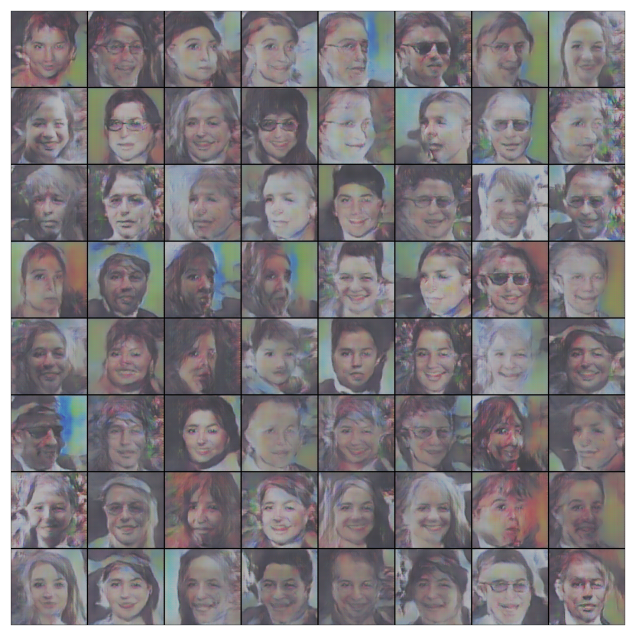

KeyboardInterrupt: 

In [34]:
losses_g, losses_d, real_scores, fake_scores = fit(model, optimizer, criterion, 20, train_loader)

In [35]:
torch.save(model['generator'].state_dict(), 'model_g.pth')
torch.save(model['discriminator'].state_dict(), 'model_d.pth')

In [23]:
model['generator'].load_state_dict(torch.load('/kaggle/input/weights-ganss/model_g.pth'))
model['discriminator'].load_state_dict(torch.load('/kaggle/input/weights-ganss/model_d.pth'))

<All keys matched successfully>

In [36]:
from IPython.display import FileLink
FileLink(r'model_g.pth')

/kaggle/working/model_g.pth

In [37]:
FileLink(r'model_d.pth')

/kaggle/working/model_d.pth

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [131]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses, ylim=(0,1)):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Generator loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Discriminator Loss')

    # Adding title, labels and formatting
    axis.set_title('Generator and Discriminator Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(ylim)

    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

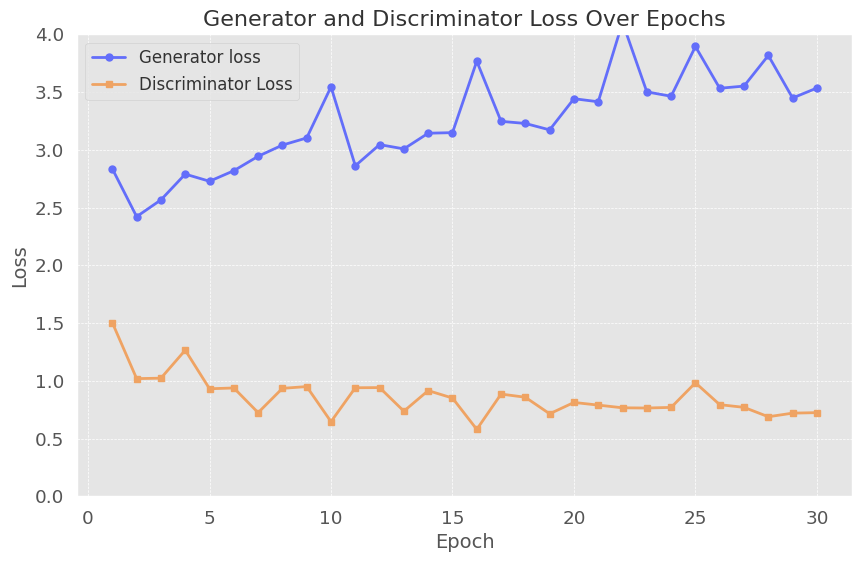

In [133]:
plot_learning_curves(losses_g, losses_d, ylim=(0, 4))

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

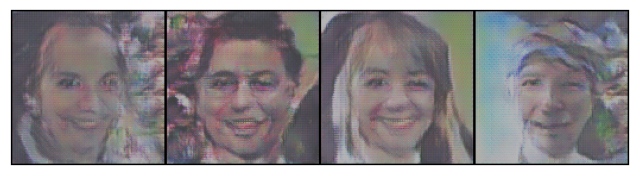

In [29]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
show_sample(fixed_latent, denorm_=True)

Как вам качество получившихся изображений?
на самом деле неплохо )))

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [33]:
fake_data_vectors = torch.randn(len(dataset), latent_size, 1, 1, device=device)
fake_dataset = generator(fake_data_vectors)

true_labels = np.ones(len(dataset))
fake_labels = np.zeros(len(dataset))

In [93]:
from tqdm import tqdm
temp = []
for i in tqdm(range(len(dataset))):
    temp.append(dataset[i])

100%|██████████| 3143/3143 [02:21<00:00, 22.28it/s]


In [52]:
# merge fake and real pictures and thier labels:
merged_dataset = np.vstack((fake_dataset.cpu().detach().numpy(), temp))
merged_labels = np.hstack((fake_labels, true_labels))

In [65]:
merged_dataset[1].shape

(3, 128, 128)

In [72]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

correct_predictions = 0

# Проведение кросс-валидации
for train_index, test_index in tqdm(loo.split(merged_dataset)):
    X_train, X_test = merged_dataset[train_index], merged_dataset[test_index]
    y_train, y_test = merged_labels[train_index], merged_labels[test_index]
    
    X_train = X_train.reshape(-1, 128 * 128 * 3)
    X_test = X_test.reshape(-1, 128 * 128 * 3)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    if y_pred == y_test:
        correct_predictions += 1

accuracy = correct_predictions / len(merged_labels)
print(f'Accuracy: {accuracy}')

6286it [2:04:12,  1.19s/it]

Accuracy: 0.7408526885141584


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

0.74 результат хороший для ванильного GAN'a я думаю. Поскольку класс у нас сбалансированный, то в идеале хотелось бы получить результат 0.5 что бы оказалось что модель не умеет различать фейковые картинки от настоящих

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [105]:
reshaped_real = np.array([x.reshape(3 * 128 * 128) for x in temp])
reshaped_fake = np.array([x.reshape(3 * 128 * 128) for x in fake_dataset.cpu().detach().numpy()])

In [111]:
from sklearn.manifold import TSNE
  
tsne_fake = TSNE(n_components=2, random_state=42)
tsne_real = TSNE(n_components=2, random_state=42)

fake_2d = tsne_fake.fit_transform(reshaped_fake) # получаем двумерное представление векторов
real_2d = tsne_real.fit_transform(reshaped_real)

In [116]:
import matplotlib.pyplot as plt
def plot_latent_space(real_images, fake_images):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Первый график
    axes[0].scatter(real_images[:, 0], real_images[:, 1], alpha=0.5)
    axes[0].set_title('t-SNE Projection of real images')
    axes[0].set_xlabel('Component 1')
    axes[0].set_ylabel('Component 2')
    
    # Второй график
    axes[1].scatter(fake_images[:, 0], fake_images[:, 1], alpha=0.5)
    axes[1].set_title('t-SNE Projection of fake images')
    axes[1].set_xlabel('Component 1')
    axes[1].set_ylabel('Component 2')
    
    plt.show()

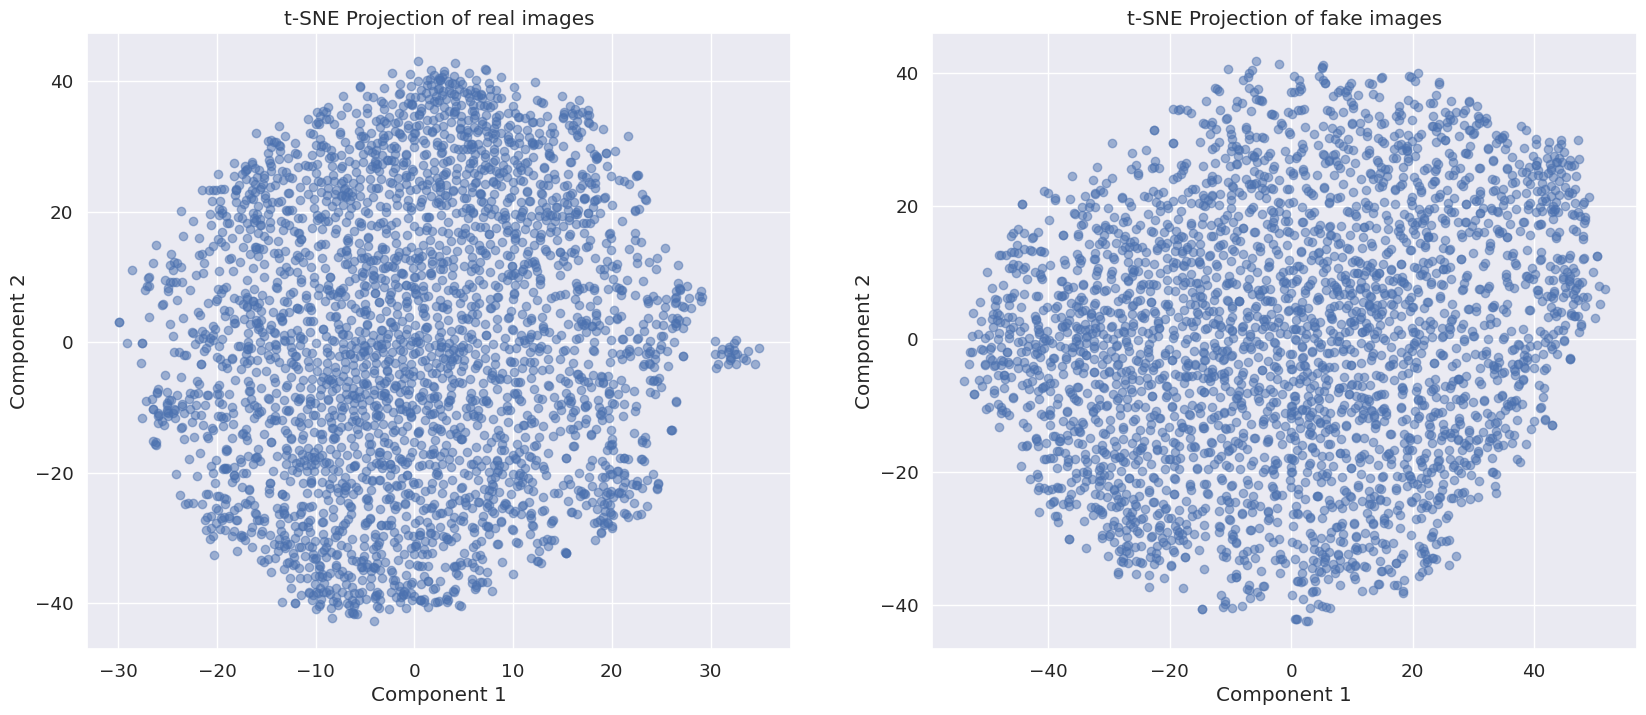

In [117]:
plot_latent_space(real_2d, fake_2d)

Прокомментируйте получившийся результат:


Реальные изображения оказались более компактными чем фейковые, размах где то от -30 до 30, в случае фейковых это даже более интервала -40 - 40. На самом деле в целом латентные представления обоих групп изображений очень похожи